<a href="https://colab.research.google.com/github/idanh8/IoT_project_accelerometer_data/blob/main/IoT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Model for Predicting Activity Type - Training

## Setup

### Imports

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
import pandas as pd
import numpy as np
import zipfile
import io
import re
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
def norm(x, y, z):
  return (x**2 + y**2 + z**2)**0.5

### Data

In [124]:
zip_path = '/content/drive/MyDrive/University/data_set.zip'
bad_eggs =[]
count = 0
datasets = {}
current_group = 0
current_person = 0
with zipfile.ZipFile(zip_path, 'r') as z:
   for file_name in z.namelist():
    if file_name == '8_walk_4_3.csv':
      continue
    file_data = {}
    count += 1
    csv_data = z.read(file_name)

    header = csv_data.decode().split('\n')[:5]
    header = [item.lower() for item in header]
    header = [item.replace('"', '') for item in header]
    rows = csv_data.decode().split('\n')[5:]
    df = pd.read_csv(io.StringIO('\n'.join(rows)))
    activity = 0 if ('walk' in header[0] or 'walking' in header[2]) else 1
    steps = int(header[3].split(',')[1])


    file_data.update([('Name', file_name),('Data', df), ('Steps', steps), ('Activity', activity)])
    exec(f"datasets[{count-1}] = file_data")
print(f'There are {count} files in the dataset')

There are 243 files in the dataset


In [125]:
problems = ['11_walk_5_1.csv', '6_run_3_1.csv', '6_run_4_1.csv','11_walk_1_1.csv', '11_walk_2_1.csv', '11_walk_3_1.csv', '6_walk_5_1.csv']
for dataset in datasets.values():
  if dataset['Name'] in problems:
    df = dataset['Data']
    df = df.drop(0)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '16_run_3_1.csv':
    df = dataset['Data']
    df = df.drop(106)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '1_walk_4_1.csv':
    df = dataset['Data']
    df = df[:995]
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '31_walk_2_1.csv':
    df = dataset['Data']
    df = df.drop(207)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '4_run_2_2.csv':
    df = dataset['Data']
    df = df.drop(185)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '4_walk_1_3.csv':
    df = dataset['Data']
    df = df.drop(368)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '4_walk_2_3.csv':
    df = dataset['Data']
    df = df.drop(95)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '4_walk_4_2.csv':
    df = dataset['Data']
    df = df.drop(599)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '4_walk_3_2.csv':
    df = dataset['Data']
    df = df.drop(39)
    df = df.drop(41)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '5_run_3_1.csv':
    df = dataset['Data']
    df = df.drop(352)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '8_run_3_1.csv':
    df = dataset['Data']
    df = df.drop(264)
    df = df.drop(605)
    df = df.drop(606)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  if dataset['Name'] == '8_run_3_1.csv':
    df = dataset['Data']
    df = df.drop(603)
    df = df.drop(604)
    df = df.drop(605)
    df = df.reset_index(drop=True)
    dataset['Data'] = df
  df = dataset['Data']
  df['Norm'] = df.apply(lambda row: norm(float(row[1]), float(row[2]), float(row[3])), axis =1)

In [126]:
datasets[0]['Data']

,Time [sec],ACC X,ACC Y,ACC Z,Norm
0,0.000000,-9.14,3.37,-0.51,9.754824
1,0.050049,-10.40,2.79,-0.35,10.773421
2,0.100098,-9.34,2.39,-0.16,9.642266
3,0.150024,-10.47,2.55,0.51,10.788118
4,0.210083,-10.55,3.37,-0.31,11.079508
...,...,...,...,...,...
227,11.580078,-10.98,3.77,-0.78,11.635364
228,11.630005,-8.67,3.73,-1.02,9.493271
229,11.680054,-9.10,3.53,-1.26,9.841672
230,11.729980,-9.65,2.67,-1.18,10.081855


## Model

### Model Class

> Takes small batches of data samples, for intergration in the **app**




In [127]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.lrelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.lrelu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

### Data Processing

In [130]:
data_points = []
targets = []
for data in datasets.values():
  df = data['Data']
  steps = data['Steps']
  act = data['Activity']
  slices = np.arange(0, len(df), 7)
  for sliver in slices:
    if (sliver + 7) > len(df):
      continue
    sliver = df.loc[sliver:sliver+6]
    acc = np.array(sliver.iloc[:, [1, 2, 3, 4]].values, dtype='float32')
    flat = torch.tensor(acc.reshape(1, -1))
    #count = torch.Tensor(np.repeat(steps, flat.shape[0]))
    #final = torch.cat((flat, count.unsqueeze(1)), dim=1)
    data_points.append(flat)
    targets.append(act)

In [131]:
stacked = torch.stack(data_points)
label_tensor = torch.tensor(targets)
dataset = TensorDataset(stacked, label_tensor)

num_samples = len(dataset)
num_train_samples = int(0.7 * num_samples)
num_test_samples = int(0.15 * num_samples)
num_eval_samples = num_samples - num_train_samples - num_test_samples
train_dataset, test_dataset, eval_dataset = random_split(dataset, [num_train_samples, num_test_samples, num_eval_samples])

### Model Training & Evaluation

In [152]:
model = Model(stacked.shape[-1], 1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 250
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.train()
num_epochs = 200

train_losses = []
train_accuracies = []
val_accuracies = []
val_losses = []
for epoch in range(num_epochs):
    train_predictions = []
    train_labels = []
    for batch in dataloader:
        batch_tensor, batch_labels = batch
        batch_tensor = batch_tensor.to(device)
        batch_labels = batch_labels.to(device)
        output = model(batch_tensor)
        target = batch_labels.view(output.size()).float()
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted_classes = torch.round(output).squeeze(dim=1)
        train_predictions.extend(predicted_classes.tolist())
        train_labels.extend(batch_labels.tolist())
    accuracy = accuracy_score(train_labels, train_predictions)
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    model.eval()
    with torch.no_grad():
      eval_predictions = []
      eval_labels = []
      for batch in eval_dataloader:
          batch_tensor, batch_labels = batch
          batch_tensor = batch_tensor.to(device)
          batch_labels = batch_labels.to(device)
          output = model(batch_tensor)
          target = batch_labels.view(output.size()).float()
          loss = criterion(output, target)
          predicted_classes = torch.round(output).squeeze(dim=1)
          eval_predictions.extend(predicted_classes.tolist())
          eval_labels.extend(batch_labels.tolist())
      accuracy = accuracy_score(eval_labels, eval_predictions)
      val_losses.append(loss.item())
      val_accuracies.append(accuracy)
      if (epoch+1)%10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {round(loss.item(),4)}, Accuracy: {round(accuracy, 4)}")

Epoch [10/200], Loss: 0.1425, Accuracy: 0.9283
Epoch [20/200], Loss: 0.124, Accuracy: 0.9347
Epoch [30/200], Loss: 0.1159, Accuracy: 0.9375
Epoch [40/200], Loss: 0.1335, Accuracy: 0.9347
Epoch [50/200], Loss: 0.1482, Accuracy: 0.9384
Epoch [60/200], Loss: 0.1342, Accuracy: 0.9356
Epoch [70/200], Loss: 0.1369, Accuracy: 0.9398
Epoch [80/200], Loss: 0.1265, Accuracy: 0.9378
Epoch [90/200], Loss: 0.1324, Accuracy: 0.9364
Epoch [100/200], Loss: 0.1348, Accuracy: 0.9395
Epoch [110/200], Loss: 0.1349, Accuracy: 0.9395
Epoch [120/200], Loss: 0.1449, Accuracy: 0.9395
Epoch [130/200], Loss: 0.1543, Accuracy: 0.9347
Epoch [140/200], Loss: 0.1491, Accuracy: 0.9358
Epoch [150/200], Loss: 0.1553, Accuracy: 0.94
Epoch [160/200], Loss: 0.1642, Accuracy: 0.937
Epoch [170/200], Loss: 0.1699, Accuracy: 0.9412
Epoch [180/200], Loss: 0.1667, Accuracy: 0.9395
Epoch [190/200], Loss: 0.1768, Accuracy: 0.9384
Epoch [200/200], Loss: 0.1676, Accuracy: 0.9426


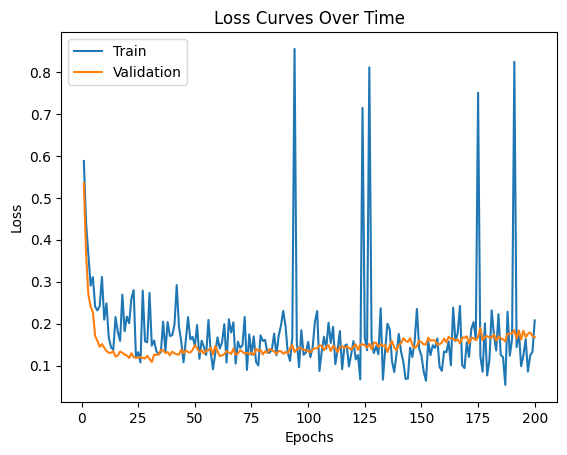

In [155]:
epochs = [i for i in range(1, num_epochs+1)]
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, val_losses, label='Validation')
plt.title('Loss Curves Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

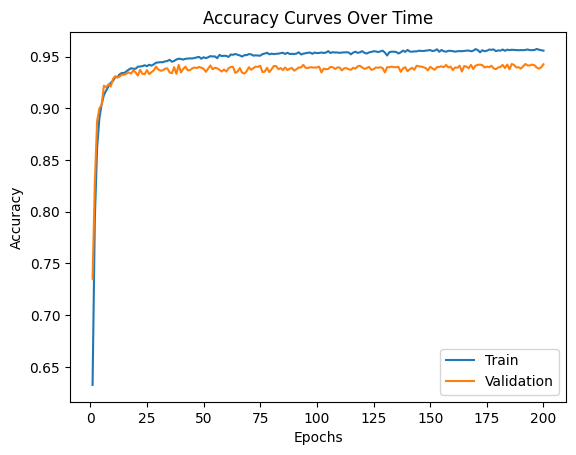

In [154]:
plt.plot(epochs, train_accuracies, label='Train')
plt.plot(epochs, val_accuracies, label='Validation')
plt.title('Accuracy Curves Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [156]:
model.eval()
with torch.no_grad():
  test_predictions = []
  test_labels = []
  for batch in test_dataloader:
      batch_tensor, batch_labels = batch
      batch_tensor = batch_tensor.to(device)
      batch_labels = batch_labels.to(device)
      output = model(batch_tensor)
      predicted_classes = torch.round(output).squeeze(dim=1)
      test_predictions.extend(predicted_classes.tolist())
      test_labels.extend(batch_labels.tolist())
  accuracy = accuracy_score(test_labels, test_predictions)
  print(f"Accuracy: {accuracy}")

Accuracy: 0.9417040358744395


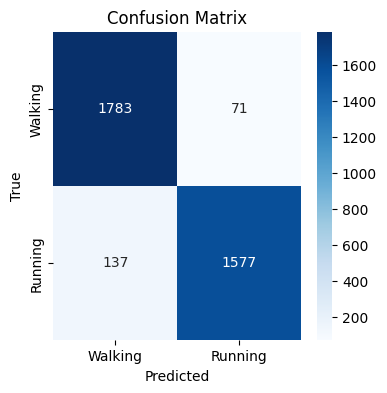

In [160]:
matrix = confusion_matrix(test_labels, test_predictions)
class_labels = ['Walking', 'Running']

plt.figure(figsize=(4, 4))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [167]:
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.96
Recall: 0.92


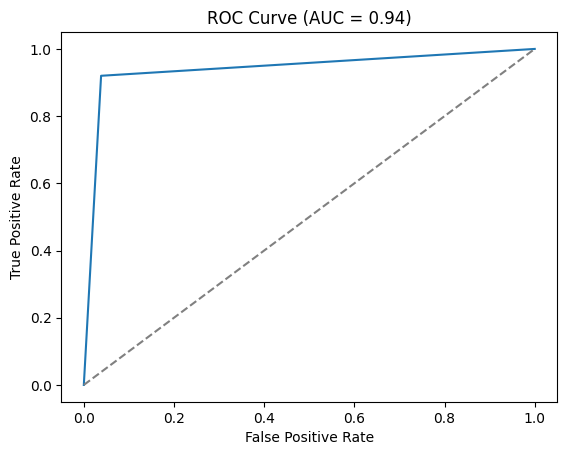

In [163]:
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_predictions)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(auc))
plt.show()

In [ ]:
with open("activity_net.pkl", "wb") as f:
  pickle.dump(model, f)

### Train on all data

In [ ]:
dataset = TensorDataset(stacked, label_tensor)
model = Model(stacked.shape[-1], 1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 250
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.train()
num_epochs = 100


for epoch in tqdm(range(num_epochs)):
    for batch in dataloader:
        batch_tensor, batch_labels = batch
        batch_tensor = batch_tensor.to(device)
        batch_labels = batch_labels.to(device)
        output = model(batch_tensor)
        target = batch_labels.view(output.size()).float()
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
torch.set_printoptions(sci_mode=False, precision=7)
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"Weight matrix of layer {name}:")
        print(param.data)
        print()
    elif 'bias' in name:
        print(f"Bias Vector ({name}):")
        print(param.data)

Weight matrix of layer fc1.weight:
tensor([[     0.0604353,      0.0059299,     -0.2285128,      0.0387725,
              0.1836419,     -0.0440568,     -0.0987561,      0.1902702,
              0.2755782,     -0.1080983,     -0.0447831,      0.2472759,
              0.3047139,     -0.0258612,     -0.2987202,      0.1815877,
              0.1944320,     -0.2662191,     -0.1482775,      0.0448390,
             -0.0074251,     -0.0211261,     -0.1505054,     -0.1415648,
              0.4772506,     -0.2851114,      0.0358519,      0.2340990],
        [    -0.4513517,     -0.3837094,     -0.4312678,      0.1421755,
             -0.0818676,     -0.1450455,     -0.3768971,      0.1202434,
             -0.0862693,     -0.0627197,     -0.0254138,     -0.0434969,
             -0.1030149,      0.1308757,     -0.1767980,      0.0826210,
             -0.5066044,     -0.2542349,     -0.4269018,     -0.0200893,
             -0.2877821,      0.0829171,     -0.6340328,      0.0277386,
             -0

### Testing for single tensors

In [ ]:
model = pickle.load(open('activity_net.pkl', 'rb'))
test_tensor = torch.tensor([[ 1, -0.2,  -5.8099999,  -0.333,  -3.4500000,
           -5.3000002,   2.3099999,   6.7326517,  -0.2400000,  -4.0799999,
            1.6900001,   4.4226804,   1.1799999,  -0.2400000,  -1.9600000,
            2.3003478,   3.2200000,   1.6900001,  -3.7300000,   5.2093568,
            2.4700000,   0.8600000,  0.1,   6.1173034,  -3.3699999,
           -1.7300000,  -2.3900001,   4.4790511]]).to(torch.float32)
test_label = torch.tensor([1])
t_dataset = TensorDataset(test_tensor, test_label)
t_dataloader = DataLoader(t_dataset, batch_size=1)
model.eval()
with torch.no_grad():
  test_predictions = []
  test_labels = []
  for batch in t_dataloader:
      batch_tensor, batch_labels = batch
      batch_tensor = batch_tensor.to(device)
      batch_labels = batch_labels.to(device)
      output = model(batch_tensor)
      print(output)
      predicted_classes = torch.round(output).squeeze(dim=1)
      test_predictions.extend(predicted_classes.tolist())
      test_labels.extend(batch_labels.tolist())
  accuracy = accuracy_score(test_labels, test_predictions)
  print(f"Accuracy: {accuracy}")

FC1: tensor([[ 5.7816715,  4.6327167,  1.9491143, -0.6903415,  5.5383663, -2.2793076,
         -3.4852827, -1.5026067, -0.8206928,  1.5749328, -0.9273030, -2.0477343,
          3.5862856, -1.7270983,  1.4175705, -0.4509810]])
ReLu: tensor([[5.7816715, 4.6327167, 1.9491143, 0.0000000, 5.5383663, 0.0000000,
         0.0000000, 0.0000000, 0.0000000, 1.5749328, 0.0000000, 0.0000000,
         3.5862856, 0.0000000, 1.4175705, 0.0000000]])
FC2: tensor([[-1.2726983,  1.7841893, -0.0695964, -6.8896341,  0.1914634,  2.4739311,
          0.8676058, -2.0555439]])
LRelu: tensor([[    -0.0127270,      1.7841893,     -0.0006960,     -0.0688963,
              0.1914634,      2.4739311,      0.8676058,     -0.0205554]])
FC3: tensor([[-0.3361164]])
Sigmoid: tensor([[0.4167532]])
tensor([[0.4167532]])
Accuracy: 0.0


# 2. Model for Predicting Activity Type

> Takes full dataframe, as required for the project




## Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import io
import re
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

## Utility Functions

In [ ]:
def norm(x, y, z):
  return (x**2 + y**2 + z**2)**0.5

In [ ]:
def process_raw(zip_path):
  count = 0
  datasets = {}
  with zipfile.ZipFile(zip_path, 'r') as z:
    for file_name in z.namelist():
      if file_name == '8_walk_4_3.csv':
        continue
      file_data = {}
      count += 1
      csv_data = z.read(file_name)

      header = csv_data.decode().split('\n')[:5]
      header = [item.lower() for item in header]
      header = [item.replace('"', '') for item in header]
      rows = csv_data.decode().split('\n')[5:]
      df = pd.read_csv(io.StringIO('\n'.join(rows)))
      activity = 0 if ('walk' in header[0] or 'walking' in header[2]) else 1
      steps = int(header[3].split(',')[1])


      file_data.update([('Name', file_name),('Data', df), ('Steps', steps), ('Activity', activity)])
      exec(f"datasets[{count-1}] = file_data")
  print(f'There are {count} files in the dataset')
  problems = ['11_walk_5_1.csv', '6_run_3_1.csv', '6_run_4_1.csv','11_walk_1_1.csv', '11_walk_2_1.csv', '11_walk_3_1.csv', '6_walk_5_1.csv']
  for dataset in datasets.values():
    if dataset['Name'] in problems:
      df = dataset['Data']
      df = df.drop(0)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '16_run_3_1.csv':
      df = dataset['Data']
      df = df.drop(106)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '1_walk_4_1.csv':
      df = dataset['Data']
      df = df[:995]
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '31_walk_2_1.csv':
      df = dataset['Data']
      df = df.drop(207)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_run_2_2.csv':
      df = dataset['Data']
      df = df.drop(185)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_walk_1_3.csv':
      df = dataset['Data']
      df = df.drop(368)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_walk_2_3.csv':
      df = dataset['Data']
      df = df.drop(95)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_walk_4_2.csv':
      df = dataset['Data']
      df = df.drop(599)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_walk_3_2.csv':
      df = dataset['Data']
      df = df.drop(39)
      df = df.drop(41)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '5_run_3_1.csv':
      df = dataset['Data']
      df = df.drop(352)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '8_run_3_1.csv':
      df = dataset['Data']
      df = df.drop(264)
      df = df.drop(605)
      df = df.drop(606)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '8_run_3_1.csv':
      df = dataset['Data']
      df = df.drop(603)
      df = df.drop(604)
      df = df.drop(605)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    df = dataset['Data']
    df['Norm'] = df.apply(lambda row: norm(float(row[1]), float(row[2]), float(row[3])), axis =1)
  return datasets

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.lrelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.lrelu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [ ]:
def generate_dataset(dataset):
    data = []
    df = dataset['Data']
    df['Norm'] = df.apply(lambda row: norm(float(row[1]), float(row[2]), float(row[3])), axis =1)
    steps = dataset['Steps']
    act = dataset['Activity']
    slices = np.arange(0, len(df), 7)
    for sliver in slices:
      if (sliver + 7) > len(df):
        continue
      sliver = df.loc[sliver:sliver+6]
      acc = np.array(sliver.iloc[:, [1, 2, 3, 4]].values, dtype='float32')
      flat = torch.tensor(acc.reshape(1, -1))
      data.append(flat)
    stacked = torch.stack(data).to(torch.float32)
    label_tensor = torch.ones(stacked.shape[0])
    final_dataset = TensorDataset(stacked, label_tensor)
    return final_dataset, stacked.shape[0]

##Model

In [ ]:
zip_path = '/content/drive/MyDrive/University/data_set.zip'
data = process_raw(zip_path)

There are 243 files in the dataset


In [ ]:
model = pickle.load(open('activity_net.pkl', 'rb'))

In [ ]:
data[0]['Activity']

1

In [ ]:
outcomes = []
for dataset in data.values():
    testset, batch_size = generate_dataset(dataset)
    true_label = dataset['Activity']
    dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model.eval()
    with torch.no_grad():
      for batch in dataloader:
          batch_tensor, batch_labels = batch
          batch_tensor = batch_tensor.to(device)
          batch_labels = batch_labels.to(device)
          output = model(batch_tensor)
          predicted_class = torch.round(output).squeeze(dim=1)
          final_pred = 0 if predicted_class.mean() < 0.5 else 1
          acc = 1 if final_pred == true_label else 0
          activity = 'Walking' if final_pred == 0 else 'Running'
    outcomes.append(acc)

In [ ]:
print(f'Final Accuracy: {sum(outcomes)/len(outcomes)}')

Final Accuracy: 0.9835390946502057


# 3. Model for Counting Steps - Training

## Setup

### Imports

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,  GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from scipy.stats import randint, uniform

In [ ]:
dataframes = []
for dataset in datasets.values():
    steps = dataset['Steps']
    act = dataset['Activity']
    df = dataset['Data']
    new_df = pd.DataFrame()
    new_df['X'] = df.iloc[:,1]
    new_df['Y'] = df.iloc[:,2]
    new_df['Z'] = df.iloc[:,3]
    new_df['N'] = df.iloc[:,4]
    new_df['act'] = np.repeat(act, len(df))
    new_df['steps'] = np.repeat(steps, len(df))
    dataframes.append(new_df)

### Data

In [ ]:
data = pd.concat(dataframes, ignore_index=True)
data = data.dropna()

In [ ]:
X_combined = data[['X', 'Y', 'Z', 'N', 'act']]
y = data['steps']

scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_combined_scaled, y, test_size=0.2, random_state=42)

### Feature Extraction

In [ ]:
def extract_features(data):
    features = {}

    # Statistical features
    features['mean'] = data.mean()
    features['std'] = data.std()
    features['min'] = data.min()
    features['max'] = data.max()
    features['range'] = data.max() - data.min()

    # Frequency domain features (using Fourier transform)
    fft_data = np.fft.fft(data)
    power_spectrum = np.abs(fft_data) ** 2
    features['power_spectrum_mean'] = power_spectrum.mean()
    features['power_spectrum_std'] = power_spectrum.std()

    features['custom_feature'] = data.sum() * data.std()

    return features

In [ ]:
extracted_features_list = []
y = []
for dataset in datasets.values():
    aggregated_features = {}
    df = dataset['Data'].astype(float)

    for axis in [1, 2, 3, 4]:
        axis_data = df.iloc[:,axis]
        axis_features = extract_features(axis_data)

        axis_features = {f'{axis}_{feature}': value for feature, value in axis_features.items()}

        aggregated_features.update(axis_features)

    aggregated_features['Act'] = dataset['Activity']
    y.append(dataset['Steps'])
    extracted_features_list.append(aggregated_features)

combined_df = pd.DataFrame(extracted_features_list)

In [ ]:
nan_indices = combined_df.index[combined_df.isnull().any(axis=1)].tolist()
nan_indices

[20]

In [ ]:
combined_df = combined_df.dropna()
del y[20]

## Model Tryouts

### OLS - Entire Dataset

In [ ]:
model = LinearRegression()

model.fit(X_train_full, y_train_full)
y_pred = model.predict(X_test_full)

mse = mean_squared_error(y_test_full, y_pred)
mae = mean_absolute_error(y_test_full, y_pred)
r2 = r2_score(y_test_full, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 805.8250071508819
Mean Absolute Error: 20.3566615709344
R-squared: 0.2784662521954616


### OLS

In [ ]:
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(combined_df)

X_train, X_test, y_train, y_test = train_test_split(X_combined_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

new_data = X_combined_scaled[235:] # not really new, just want to see the outcome
new_predictions = model.predict(new_data)
real_preds = y[235:]
for i in range(len(new_data)):
    print(f'True: {real_preds[i]}, Pred: {new_predictions[i]}')

Mean Squared Error: 546.9096214407115
Mean Absolute Error: 18.96399722045868
R-squared: 0.6439390485412034
True: 163, Pred: 141.9005010665283
True: 158, Pred: 137.2659753278718
True: 117, Pred: 97.92668835642704
True: 112, Pred: 93.78262687577822
True: 114, Pred: 94.37314405675002
True: 115, Pred: 90.00990130669393
True: 124, Pred: 86.00432588123672


### Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_df, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 227.48466530612242
Mean Absolute Error: 10.610612244897958
R-squared: 0.8518980043579932


### XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_df, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 189.21445601512966
Mean Absolute Error: 10.162956354569415
R-squared: 0.8768135051984833


### Neural Network

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_df, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
model = NeuralNet(X_train.shape[1])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    if (epoch+1)%10 == 0:
      print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

mse = mean_squared_error(y_test_tensor, y_pred)
mae = mean_absolute_error(y_test_tensor, y_pred)
r2 = r2_score(y_test_tensor, y_pred)

print("")
print("Mean Squared Error:", mse.item())
print("Mean Absolute Error:", mae.item())
print("R-squared:", r2)

Epoch 10/200, Loss: 13239.4973
Epoch 20/200, Loss: 2368.2744
Epoch 30/200, Loss: 1182.1003
Epoch 40/200, Loss: 1103.1945
Epoch 50/200, Loss: 1066.5291
Epoch 60/200, Loss: 1015.3925
Epoch 70/200, Loss: 986.9539
Epoch 80/200, Loss: 965.1610
Epoch 90/200, Loss: 989.3163
Epoch 100/200, Loss: 970.6561
Epoch 110/200, Loss: 919.1332
Epoch 120/200, Loss: 898.8565
Epoch 130/200, Loss: 904.4056
Epoch 140/200, Loss: 896.2764
Epoch 150/200, Loss: 860.1638
Epoch 160/200, Loss: 877.5510
Epoch 170/200, Loss: 859.2656
Epoch 180/200, Loss: 844.9027
Epoch 190/200, Loss: 842.0821
Epoch 200/200, Loss: 874.0421

Mean Squared Error: 825.6380004882812
Mean Absolute Error: 23.128437042236328
R-squared: 0.46247526871211775


## Hyperparameter Tuning

### Grid Search

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_df, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 250, 300, 500, 750],
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'max_depth': [2, 3, 5, 7, 10]}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X_test)

mse = mean_squared_error(y_test, y_pred_grid)
mae = mean_absolute_error(y_test, y_pred_grid)
r2 = r2_score(y_test, y_pred_grid)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)
print("Best Hyperparameters:", grid_search.best_params_)

Mean Squared Error: 169.32762479763522
Mean Absolute Error: 9.193273388609594
R-squared: 0.8897606609390396
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 750}


### Random Search

In [ ]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10)}


model = xgb.XGBRegressor()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5,
                                   scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
best_model_rand = random_search.best_estimator_
y_pred_rand = best_model_rand.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rand)
mae = mean_absolute_error(y_test, y_pred_rand)
r2 = r2_score(y_test, y_pred_rand)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)
print("Best Hyperparameters:", random_search.best_params_)

Mean Squared Error: 142.3514344745719
Mean Absolute Error: 8.4865218960509
R-squared: 0.907323284847284
Best Hyperparameters: {'learning_rate': 0.16743239807751675, 'max_depth': 9, 'n_estimators': 781}


### Bayesian Search

In [ ]:
param_space = {
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'max_depth': (3, 10)}

bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, n_iter=10, cv=5,
                             scoring='neg_mean_squared_error', random_state=42)
bayes_search.fit(X_train, y_train)
best_model_bayes = bayes_search.best_estimator_
y_pred_bayes = best_model_bayes.predict(X_test)

mse = mean_squared_error(y_test, y_pred_bayes)
mae = mean_absolute_error(y_test, y_pred_bayes)
r2 = r2_score(y_test, y_pred_bayes)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)
print("Best Hyperparameters:", bayes_search.best_params_)

Mean Squared Error: 156.57103013231645
Mean Absolute Error: 8.822747444619937
R-squared: 0.8980657355909398
Best Hyperparameters: OrderedDict([('learning_rate', 0.15849201309311142), ('max_depth', 4), ('n_estimators', 638)])


## Plots

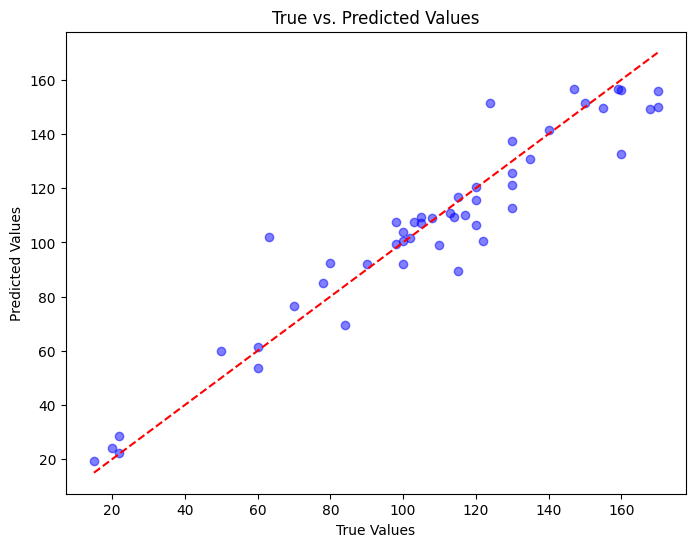

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rand, color='b', alpha=0.5)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.show()

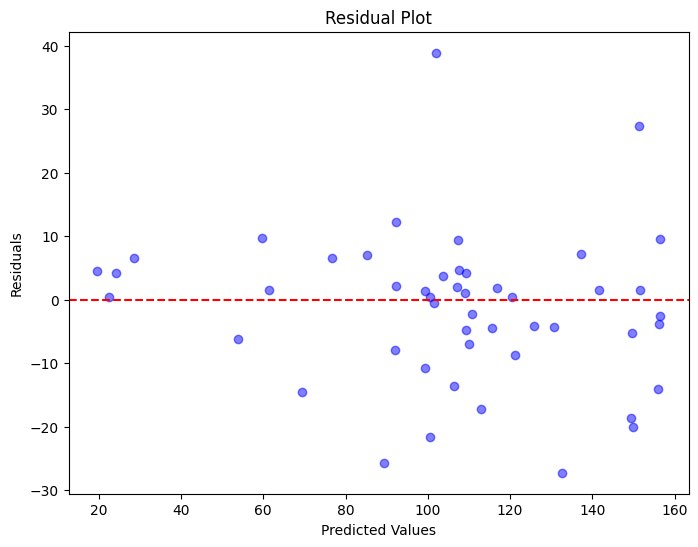

In [ ]:
residuals = y_pred_rand - y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rand, residuals, color='b', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

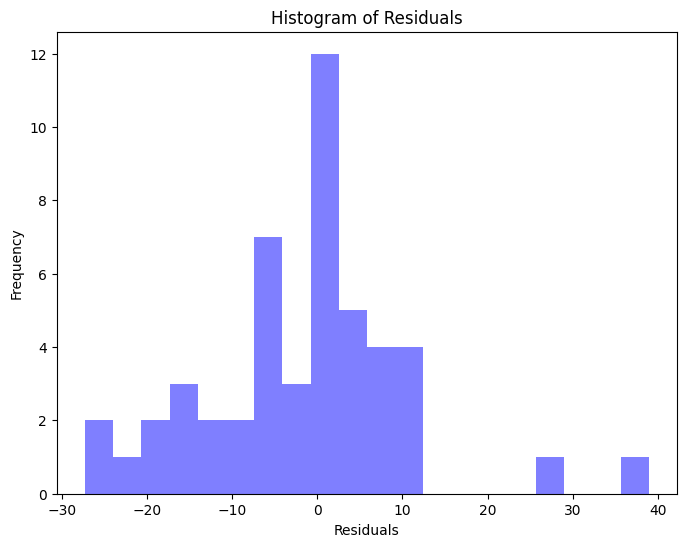

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='b', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# 4. Model for Counting Steps

> Recieves a full csv as required by project



## Imports

In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,  GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from scipy.stats import randint, uniform

## Utilities

In [95]:
def process_raw(zip_path):
  count = 0
  datasets = {}
  with zipfile.ZipFile(zip_path, 'r') as z:
    for file_name in z.namelist():
      if file_name == '8_walk_4_3.csv':
        continue
      file_data = {}
      count += 1
      csv_data = z.read(file_name)

      header = csv_data.decode().split('\n')[:5]
      header = [item.lower() for item in header]
      header = [item.replace('"', '') for item in header]
      rows = csv_data.decode().split('\n')[5:]
      df = pd.read_csv(io.StringIO('\n'.join(rows)))
      activity = 0 if ('walk' in header[0] or 'walking' in header[2]) else 1
      steps = int(header[3].split(',')[1])


      file_data.update([('Name', file_name),('Data', df), ('Steps', steps), ('Activity', activity)])
      exec(f"datasets[{count-1}] = file_data")
  print(f'There are {count} files in the dataset')
  problems = ['11_walk_5_1.csv', '6_run_3_1.csv', '6_run_4_1.csv','11_walk_1_1.csv', '11_walk_2_1.csv', '11_walk_3_1.csv', '6_walk_5_1.csv']
  for dataset in datasets.values():
    if dataset['Name'] in problems:
      df = dataset['Data']
      df = df.drop(0)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '16_run_3_1.csv':
      df = dataset['Data']
      df = df.drop(106)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '1_walk_4_1.csv':
      df = dataset['Data']
      df = df[:995]
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '31_walk_2_1.csv':
      df = dataset['Data']
      df = df.drop(207)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_run_2_2.csv':
      df = dataset['Data']
      df = df.drop(185)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_walk_1_3.csv':
      df = dataset['Data']
      df = df.drop(368)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_walk_2_3.csv':
      df = dataset['Data']
      df = df.drop(95)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_walk_4_2.csv':
      df = dataset['Data']
      df = df.drop(599)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '4_walk_3_2.csv':
      df = dataset['Data']
      df = df.drop(39)
      df = df.drop(41)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '5_run_3_1.csv':
      df = dataset['Data']
      df = df.drop(352)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '8_run_3_1.csv':
      df = dataset['Data']
      df = df.drop(264)
      df = df.drop(605)
      df = df.drop(606)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    if dataset['Name'] == '8_run_3_1.csv':
      df = dataset['Data']
      df = df.drop(603)
      df = df.drop(604)
      df = df.drop(605)
      df = df.reset_index(drop=True)
      dataset['Data'] = df
    df = dataset['Data']
    df['Norm'] = df.apply(lambda row: norm(float(row[1]), float(row[2]), float(row[3])), axis =1)
  return datasets

In [96]:
def extract_features(data):
    features = {}

    # Statistical features
    features['mean'] = data.mean()
    features['std'] = data.std()
    features['min'] = data.min()
    features['max'] = data.max()
    features['range'] = data.max() - data.min()

    # Frequency domain features (using Fourier transform)
    fft_data = np.fft.fft(data)
    power_spectrum = np.abs(fft_data) ** 2
    features['power_spectrum_mean'] = power_spectrum.mean()
    features['power_spectrum_std'] = power_spectrum.std()

    features['custom_feature'] = data.sum() * data.std()

    return features

In [97]:
def combine_and_extract(datasets):
    extracted_features_list = []
    y = []
    for dataset in datasets.values():
        aggregated_features = {}
        df = dataset['Data'].astype(float)

        for axis in [1, 2, 3, 4]:
            axis_data = df.iloc[:,axis]
            axis_features = extract_features(axis_data)

            axis_features = {f'{axis}_{feature}': value for feature, value in axis_features.items()}

            aggregated_features.update(axis_features)

        aggregated_features['Act'] = dataset['Activity']
        y.append(dataset['Steps'])
        extracted_features_list.append(aggregated_features)

    combined_df = pd.DataFrame(extracted_features_list)
    nan_indices = combined_df.index[combined_df.isnull().any(axis=1)].tolist()
    combined_df = combined_df.dropna()
    del y[nan_indices[0]]
    return combined_df, y

In [115]:
def single_combine_and_extract(datasets):
    extracted_features_list = []
    y = []
    aggregated_features = {}
    df = dataset['Data'].astype(float)

    for axis in [1, 2, 3, 4]:
        axis_data = df.iloc[:,axis]
        axis_features = extract_features(axis_data)

        axis_features = {f'{axis}_{feature}': value for feature, value in axis_features.items()}

        aggregated_features.update(axis_features)

    aggregated_features['Act'] = dataset['Activity']
    y.append(dataset['Steps'])
    extracted_features_list.append(aggregated_features)

    combined_df = pd.DataFrame(extracted_features_list)
    combined_df = combined_df.dropna()
    return combined_df, y

## Model

In [98]:
zip_path = '/content/drive/MyDrive/University/data_set.zip'
data = process_raw(zip_path)
combined_df, y = combine_and_extract(data)

There are 243 files in the dataset


In [119]:
test_data, test_labels = single_combine_and_extract(data[50])

In [120]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(combined_df)

model = xgb.XGBRegressor(learning_rate=0.16743239807751675, max_depth=9, n_estimators=781)
model.fit(combined_df, y)

y_pred = model.predict(test_data)
for i in range(len(test_labels)):
  print(f'True: {test_labels[i]}, Predicted: {y_pred[i]}')

mse = mean_squared_error(test_labels, y_pred)
mae = mean_absolute_error(test_labels, y_pred)
r2 = r2_score(test_labels, y_pred)

print("")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

True: 124, Predicted: 123.99932098388672

Mean Squared Error: 4.6106288209557533e-07
Mean Absolute Error: 0.00067901611328125


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
